# Async optimization Loop

Tim Head, February 2017.

In [2]:
import numpy as np
np.random.seed(1234)

%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

<Figure size 432x288 with 0 Axes>

Bayesian optimization is used to tune parameters for walking robots or other experiments
that are not a simple (expensive) function call.

They often follow a pattern a bit like this:
1. ask for a new set of parameters
1. walk to the experiment and program in the new parameters
1. observe the outcome of running the experiment
1. walk back to your laptop and tell the optimizer about the outcome
1. go to step 1

A setup like this is difficult to implement with the `*_minimize()` function interface.
This is why `scikit-optimize` has a ask-and-tell interface that you can use when you want
to control the execution of the optimization loop.

This notenook demonstrates how to use the ask and tell interface.


## The Setup

We will use a simple 1D problem to illustrate the API. This is a
little bit artificial as you normally would not use the ask-and-tell
interface if you had a function you can call to evaluate the objective.

In [3]:
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer

noise_level = 0.1

# Our 1D toy problem, this is the function we are trying to
# minimize
def objective(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

/Users/nimishawalgaonkar/anaconda2/envs/scikit_optimize_develop/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Here a quick plot to visualize what the function looks like:

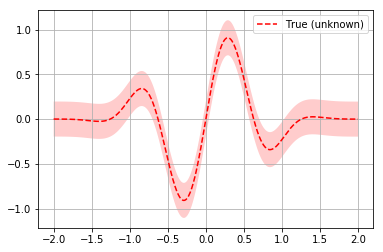

In [4]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = np.array([objective(x_i, noise_level=0.0) for x_i in x])
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

Now we setup the `Optimizer` class. The arguments follow the meaning
and naming of the `*_minimize()` functions. An important difference
is that you do not pass the objective function to the optimizer.

In [5]:
opt = Optimizer([(-2.0, 2.0)], "ET", acq_optimizer="sampling")

To obtain a suggestion for the point at which to evaluate the objective
you call the `ask()` method of `opt`:

In [6]:
next_x = opt.ask()
print(next_x)

[-1.7121321838148869]


In a real world use case you would probably go away and use this parameter in your
experiment and come back a while later with the result. In this example we can
simply evaluate the objective function and report the value back to the
optimizer:

In [7]:
f_val = objective(next_x)
opt.tell(next_x, f_val)

          fun: -0.032758350111535384
    func_vals: array([-0.03275835])
       models: []
 random_state: <mtrand.RandomState object at 0x107ddd798>
        space: Space([Real(low=-2.0, high=2.0, prior='uniform', transform='identity')])
        specs: None
            x: [-1.7121321838148869]
      x_iters: [[-1.7121321838148869]]

Like `*_minimize()` the first few points are random suggestions as there is no data
yet with which to fit a surrogate model.

In [8]:
for i in range(9):
    next_x = opt.ask()
    f_val = objective(next_x)
    opt.tell(next_x, f_val)

We can now plot the random suggestions and the first model that has been fit:

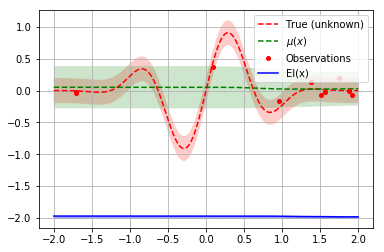

In [9]:
from skopt.acquisition import gaussian_ei

def plot_optimizer(opt, x, fx):
    model = opt.models[-1]
    x_model = opt.space.transform(x.tolist())

    # Plot true function.
    plt.plot(x, fx, "r--", label="True (unknown)")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([fx - 1.9600 * noise_level, 
                             fx[::-1] + 1.9600 * noise_level]),
             alpha=.2, fc="r", ec="None")

    # Plot Model(x) + contours
    y_pred, sigma = model.predict(x_model, return_std=True)
    plt.plot(x, y_pred, "g--", label=r"$\mu(x)$")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma, 
                             (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(opt.Xi, opt.yi,
             "r.", markersize=8, label="Observations")

    acq = gaussian_ei(x_model, model, y_opt=np.min(opt.yi))
    # shift down to make a better plot
    acq = 4*acq - 2
    plt.plot(x, acq, "b", label="EI(x)")
    plt.fill_between(x.ravel(), -2.0, acq.ravel(), alpha=0.3, color='blue')
    
    # Adjust plot layout
    plt.grid()
    plt.legend(loc='best')
    
plot_optimizer(opt, x, fx)

Let us sample a few more points and plot the optimizer again:

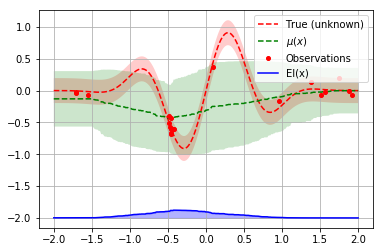

In [10]:
for i in range(10):
    next_x = opt.ask()
    f_val = objective(next_x)
    opt.tell(next_x, f_val)
    
plot_optimizer(opt, x, fx)

By using the `Optimizer` class directly you get control over the optimization loop.

You can also pickle your `Optimizer` instance if you want to end the process running it
and resume it later. This is handy if your experiment takes a very long time and you
want to shutdown your computer in the meantime:

In [11]:
import pickle

with open('my-optimizer.pkl', 'wb') as f:
    pickle.dump(opt, f)

with open('my-optimizer.pkl', 'rb') as f:
    opt_restored = pickle.load(f)